# AB Test



В данном задании вам нужно будет

    проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса

    подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами

    определить характер этих изменений и практическую значимость вводимого изменения

    понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats



Описание  данных:

    userID:  уникальный идентификатор пользователя

    browser:  браузер, который использовал userID

    slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)

    n_clicks: количество кликов, которые пользоваль совершил за n_queries

    n_queries: количество запросов, который совершил userID, пользуясь браузером browser

    n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.

In [2]:
df = pd.read_csv('ab_browser_test.csv')
df

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


## Question 1

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки. 

In [3]:
df.userID.nunique(), len(df)

(565842, 566134)

In [4]:
df.browser.value_counts(), df.slot.value_counts()

(Browser #4     156833
 Browser #22    142905
 Browser #2     110737
 Browser #14     89123
 Browser #20     33929
 Browser #17     32607
 Name: browser, dtype: int64,
 control    284554
 exp        281580
 Name: slot, dtype: int64)

In [6]:
df['unique_id'] = df.browser.str.extract('(\d+)')

In [7]:
df_exp = df[df.slot == 'exp']
df_control = df[df.slot == 'control']

In [8]:
round((df_exp.n_clicks.sum() - df_control.n_clicks.sum())/ len(df_control)*100, 4)

18.2025

In [9]:
round(100-df_exp.n_clicks.sum()/df_control.n_clicks.sum()*100, 3)

-1.614

## Question 2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [14]:
np.random.seed(42)
samples_exp_mean = np.fromiter(map(np.mean, get_bootstrap_samples(df_exp.n_clicks.values, 1000)),dtype=np.float)
samples_control_mean = np.fromiter(map(np.mean, get_bootstrap_samples(df_control.n_clicks.values, 1000)),dtype=np.float)

In [15]:
samples_exp_median = np.fromiter(map(np.median, get_bootstrap_samples(df_exp.n_clicks.values, 1000)),dtype=np.float)
samples_control_median = np.fromiter(map(np.median, get_bootstrap_samples(df_control.n_clicks.values, 1000)),dtype=np.float)

In [16]:
print('95%% confidence interval for mean diff between exp and  control %s' %
      str(stat_intervals(samples_control_mean - samples_exp_mean, 0.05)))

print('95%% confidence interval for median diff between exp and  control %s' %
      str(stat_intervals(samples_control_median - samples_exp_median, 0.05)))

95% confidence interval for mean diff between exp and  control [-0.40634881 -0.19385771]
95% confidence interval for median diff between exp and  control [-1. -1.]


## Question 4

Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса. 

     Получите из данных n_boot_samples  псевдовыборок. 

    По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared) 

    Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

    Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте  qq-plot с помощью scipy.stats.probplot  для хи-квадрат распределения с помощью команды 

In [17]:
np.random.seed(0)
n_boot_samples = 500

samples_control_mean = np.fromiter(map(np.mean, get_bootstrap_samples(df_control.n_clicks.values, n_boot_samples)),dtype=np.float)

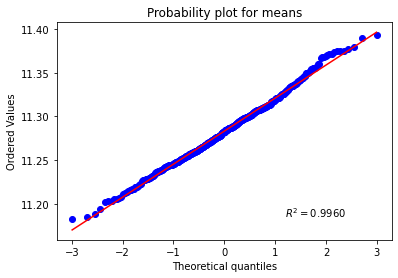

In [18]:
#probability plot for means
_ = stats.probplot(samples_control_mean, plot=plt, rvalue=True)
_ = plt.title('Probability plot for means')

In [19]:
#stats.chisquare(samples_control_mean)

In [20]:
samples_control_mean.shape[0]

500

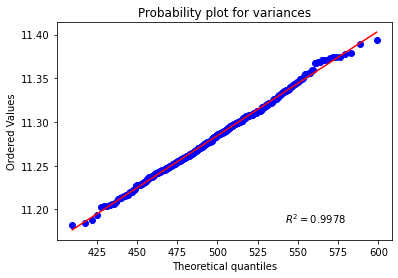

In [21]:
#probability plot for variances
_ = stats.probplot(samples_control_mean, plot=plt, dist='chi2', sparams=(samples_control_mean.shape[0]-1), rvalue=True)
_ = plt.title('Probability plot for variances')

## Question 5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

Ранговый Критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [22]:
control_group = df_control.groupby('userID')['n_clicks'].sum()
exp_group = df_exp.groupby('userID')['n_clicks'].sum()

In [23]:
stats.mannwhitneyu(control_group, exp_group)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

## Question 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05\alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [24]:
exp_browser = df_exp.groupby(['browser', 'userID'])['n_clicks'].sum()
control_browser = df_control.groupby(['browser', 'userID'])['n_clicks'].sum()

In [25]:
mannwhitneyu_p = []

for br in set(exp_browser.index.get_level_values('browser')):

    p = stats.mannwhitneyu(control_browser.loc[br, :], exp_browser.loc[br, :], alternative='two-sided')[1]
    print(br, round(p,4))
    mannwhitneyu_p.append(p)

Browser #14 0.0
Browser #17 0.0748
Browser #4 0.8152
Browser #22 0.5148
Browser #20 0.9073
Browser #2 0.0545


In [26]:
mannwhitneyu_p_corr = []
mannwhitneyu_p_corr = multipletests(mannwhitneyu_p, alpha = 0.05, method = 'holm')[1]
for i, br in enumerate(set(exp_browser.index.get_level_values('browser'))):

    print(br, round(mannwhitneyu_p_corr[i],4))

Browser #14 0.0
Browser #17 0.2992
Browser #4 1.0
Browser #22 1.0
Browser #20 1.0
Browser #2 0.2724


## Question 7

Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

In [27]:
nonclk_exp_group = df_exp.groupby(['browser', 'userID'])['n_queries'].sum()
queries_exp_group = df_exp.groupby(['browser', 'userID'])['n_nonclk_queries'].sum()
res_exp_nonclk = queries_exp_group/nonclk_exp_group * 100

In [28]:
nonclk_control_group = df_control.groupby(['browser', 'userID'])['n_queries'].sum()
queries_control_group = df_control.groupby(['browser', 'userID'])['n_nonclk_queries'].sum()
res_control_nonclk = queries_control_group/nonclk_control_group * 100

In [29]:
for br in set(exp_browser.index.get_level_values('browser')):
    print(br)
    print("exp mean: ", res_exp_nonclk.loc[br].mean())
    print("control mean: ", res_control_nonclk.loc[br].mean())
    print("")

Browser #14
exp mean:  43.10741773746228
control mean:  60.07533271615287

Browser #17
exp mean:  36.65860468273935
control mean:  36.752501806523576

Browser #4
exp mean:  43.008149012657654
control mean:  44.47622567456505

Browser #22
exp mean:  39.07220335221768
control mean:  39.43205942354982

Browser #20
exp mean:  37.86293386205641
control mean:  39.07703311337462

Browser #2
exp mean:  45.53810364447602
control mean:  46.41298410132074

